# Point 3.2

In [1]:
import torch
import torchvision
from tqdm import trange
import cv2
import copy
from torchvision import transforms
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.svm import SVC
torch.manual_seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print(device)

cpu


In [2]:
!rm best_model.pt

rm: cannot remove 'best_model.pt': No such file or directory


In [3]:
mean = [0.5224, 0.5224, 0.5224]
std = [0.2456, 0.2456, 0.2456]

train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.PILToTensor(),
    transforms.Normalize(mean = mean, std = std),
    transforms.Lambda(lambda x: x.float())
    
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.PILToTensor(),
    transforms.Normalize(mean = mean, std = std),
    transforms.Lambda(lambda x: x.float())
])

## Dataset Definition

Here we converted from grayscale to rgb because AlexNet is designed with rgb input images (also the normalization helps because in the original AlexNet model images where normalized).

Also the batches are changed because we want to use directly the whole sets.

In [4]:
image_open = lambda path: Image.open(path).convert("RGB")

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=image_open)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=image_open)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = train_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1275, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=225, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=image_open)
testloader = torch.utils.data.DataLoader(testset, batch_size=2985, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [5]:
img, _ = next(iter(trainloader))

img.size(), len(trainloader.dataset)

c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1275, 3, 224, 224]), 1275)

In [6]:
alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\goate/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\goate\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\goate\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
for param in alex_net.parameters():
    param.requires_grad = False

In [9]:
for name, param in alex_net.named_parameters():
    print(f'param name: {name} grad: {param.requires_grad}')

param name: features.0.weight grad: False
param name: features.0.bias grad: False
param name: features.3.weight grad: False
param name: features.3.bias grad: False
param name: features.6.weight grad: False
param name: features.6.bias grad: False
param name: features.8.weight grad: False
param name: features.8.bias grad: False
param name: features.10.weight grad: False
param name: features.10.bias grad: False
param name: classifier.1.weight grad: False
param name: classifier.1.bias grad: False
param name: classifier.4.weight grad: False
param name: classifier.4.bias grad: False
param name: classifier.6.weight grad: False
param name: classifier.6.bias grad: False


In [10]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [11]:
optimizer = torch.optim.Adam(alex_net.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [12]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [13]:
def get_test_predictions(model, test_loader):
    pred_tensor = torch.empty(len(testset), dtype = torch.uint8)
    labels_tensor = torch.empty_like(pred_tensor)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)

        prediction = torch.argmax(prediction, axis=1)
    
        pred_tensor = copy.deepcopy(prediction) # we have that strange equation because the dataset is not divisible by 32
        labels_tensor = copy.deepcopy(y)
    
    return (pred_tensor, labels_tensor)

In [14]:
model = torch.nn.Sequential(alex_net.features, alex_net.avgpool)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [15]:
x, y = next(iter(trainloader))

valid_x, valid_y = next(iter(validloader))

x.size(), valid_x.size(), x.std()**2

(torch.Size([1275, 3, 224, 224]),
 torch.Size([225, 3, 224, 224]),
 tensor(1.0297))

In [16]:
pred = model(x).reshape(len(trainloader.dataset), -1)

valid_pred = model(valid_x).reshape(len(validloader.dataset), -1)

pred.size(), valid_pred.size()

(torch.Size([1275, 9216]), torch.Size([225, 9216]))

In [17]:
x = pred.numpy()
y = y.numpy()

valid_x = valid_pred.numpy()
valid_y = valid_y.numpy()

## Classifier definition

In [18]:
# clf = OneVsRestClassifier(SVC(kernel='linear')).fit(x, y)

clf = OneVsRestClassifier(SVC(kernel='rbf', gamma=1e-4, C=100)).fit(x, y)

In [19]:
y_pred = clf.predict(valid_x)

print("Accuracy:",metrics.accuracy_score(valid_y, y_pred))

Accuracy: 0.8444444444444444


In [20]:
alphas_per_classifier = np.empty(15)

for i, svc in enumerate(clf.estimators_):
    alphas_per_classifier[i] = svc.support_vectors_.shape[0]

alphas_per_classifier.mean(), alphas_per_classifier.mean()/len(trainloader.dataset)

(455.53333333333336, 0.357281045751634)

c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


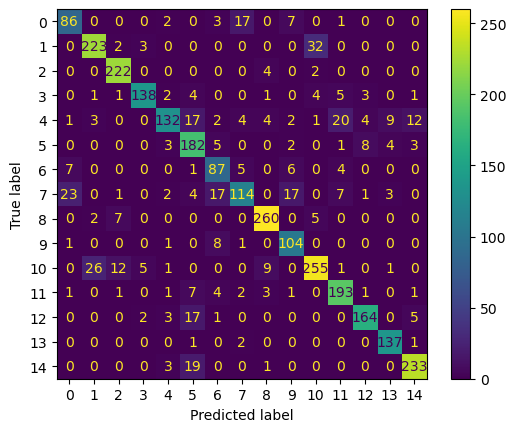

In [21]:
test_x, test_y = next(iter(testloader))

test_pred = model(test_x).reshape(len(testloader.dataset), -1)

test_x = test_pred.numpy()
test_y = test_y.numpy()

y_pred = clf.predict(test_x)


cm = confusion_matrix(test_y, y_pred, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [22]:
# GRID SEARCH LOOP

'''
for C in [0.01, 0.1, 1, 10, 100]:
    for gamma in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:
        x, y = next(iter(trainloader))

        valid_x, valid_y = next(iter(validloader))

        pred = model(x).reshape(len(trainloader.dataset), -1)

        valid_pred = model(valid_x).reshape(len(validloader.dataset), -1)

        x = pred.numpy()
        y = y.numpy()

        valid_x = valid_pred.numpy()
        valid_y = valid_y.numpy()

        clf = OneVsRestClassifier(SVC(kernel='rbf', C=C, gamma=gamma)).fit(x, y)

        y_pred = clf.predict(valid_x)

        print(f"C: {C} gamma {gamma}, Accuracy:{metrics.accuracy_score(valid_y, y_pred)}")
'''

'\nfor C in [0.01, 0.1, 1, 10, 100]:\n    for gamma in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]:\n        x, y = next(iter(trainloader))\n\n        valid_x, valid_y = next(iter(validloader))\n\n        pred = model(x).reshape(len(trainloader.dataset), -1)\n\n        valid_pred = model(valid_x).reshape(len(validloader.dataset), -1)\n\n        x = pred.numpy()\n        y = y.numpy()\n\n        valid_x = valid_pred.numpy()\n        valid_y = valid_y.numpy()\n\n        clf = OneVsRestClassifier(SVC(kernel=\'rbf\', C=C, gamma=gamma)).fit(x, y)\n\n        y_pred = clf.predict(valid_x)\n\n        print(f"C: {C} gamma {gamma}, Accuracy:{metrics.accuracy_score(valid_y, y_pred)}")\n'